### tSNE for Feature Vectors

In [4]:
import os
import glob
import json
import sys
sys.path.append("../")
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
# sns.set()

from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier

import lightgbm as lgb
from FRUFS import FRUFS

from features.preprocessing import clean_features, preprocess_df, feature_selection
from features.utils import save_json, save_npy, load_json, load_npy

In [5]:
import tensorflow as tf

def get_new_embeds(embeds, labels):
    in_ = embeds.shape[-1]

    model = tf.keras.Sequential([
        tf.keras.layers.Dense(32, activation='relu', input_shape=(in_,), name="dense_1"),
        tf.keras.layers.Dense(1, activation="sigmoid", name="dense_2")
    ])
    model.compile(
        optimizer='adam',
        loss='binary_crossentropy',
        metrics=['accuracy']
    )
    model.fit(embeds, labels, epochs=20)

    embed_model = tf.keras.Model(inputs=model.input, outputs=model.get_layer("dense_1").output)

    return np.array(embed_model.predict(embeds))

In [6]:
label_df = pd.read_csv("../data/mgmt_labels.csv")
ids = list(label_df["BraTS21ID"])
label_dict = label_df.set_index('BraTS21ID').T.to_dict('list')

run_path = "../runs/alpha_0.9_enc1"
np_paths = glob.glob(f"{run_path}/outputs/*.npy")
dl_features_dict = {}

for path in np_paths:
    id_ = int(path.split("/")[-1].split(".")[0])
    dl_features_dict[id_] = np.load(path)[0]


rad_features = load_json(os.path.join(run_path, "train_radiomics.json"))
rad_labels = load_npy(os.path.join(run_path, "train_labels.npy"))
rad_df, rad_labels, rad_ids  = clean_features(rad_features, rad_labels)
cols = list(rad_df.columns)[1:]
rad_features_dict = {}

for i, id_ in enumerate(ids):
    try:
        features = np.array(rad_df[rad_df["BraTS21ID"] == id_][cols])[0]
        rad_features_dict[id_] = features
    except:
        continue

500it [00:00, 42401.83it/s]


In [7]:
rad_feature_arr, dl_feature_arr = [], []
labels = []

for id_ in list(rad_features_dict.keys()):
    labels.append(label_dict[id_][0])
    rad_f = list(rad_features_dict[id_])
    dl_f = list(dl_features_dict[id_])

    rad_feature_arr.append(rad_f)
    dl_feature_arr.append(dl_f)

rad_feature_arr = np.array(rad_feature_arr)
dl_feature_arr = np.array(dl_feature_arr)
feature_arr = np.concatenate([rad_feature_arr, dl_feature_arr], axis=-1)

labels = np.array(labels)

In [8]:
# rad_feature_arr = get_new_embeds(rad_feature_arr, labels)
# dl_feature_arr = get_new_embeds(dl_feature_arr, labels)
# feature_arr = get_new_embeds(feature_arr, labels)

In [9]:
model_frufs_generated = FRUFS(
            model_r=lgb.LGBMRegressor(random_state=42),
            k=15
        )
rad_frufs = model_frufs_generated.fit_transform(rad_feature_arr)
dl_frufs = model_frufs_generated.fit_transform(dl_feature_arr)
ens_frufs = model_frufs_generated.fit_transform(feature_arr)

Progress bar: 100%|██████████| 521/521 [07:35<00:00,  1.14it/s]


In [10]:
def get_label(embeds, labels):
    kmeans = KMeans(2)
    labels = kmeans.fit_predict(embeds)
    return labels

In [11]:
tsne = TSNE()

rad_tsne = tsne.fit_transform(rad_feature_arr)
dl_tsne = tsne.fit_transform(dl_feature_arr)
ens_tsne = tsne.fit_transform(feature_arr)

rad_tsne_frufs = tsne.fit_transform(rad_frufs)
dl_tsne_frufs = tsne.fit_transform(dl_frufs)
ens_tsne_frufs = tsne.fit_transform(ens_frufs)

In [12]:
# fig, ax = plt.subplots(1, 3, figsize=(15,6))

# ax[0].scatter(rad_tsne[:, 0], rad_tsne[:, 1], c=labels)
# ax[0].set_title("Radiomics Features")

# ax[1].scatter(dl_tsne[:, 0], dl_tsne[:, 1], c=labels)
# ax[1].set_title("Deep Learning Features")

# ax[2].scatter(ens_tsne[:, 0], ens_tsne[:, 1], c=labels)
# ax[2].set_title("Ensemble Features")

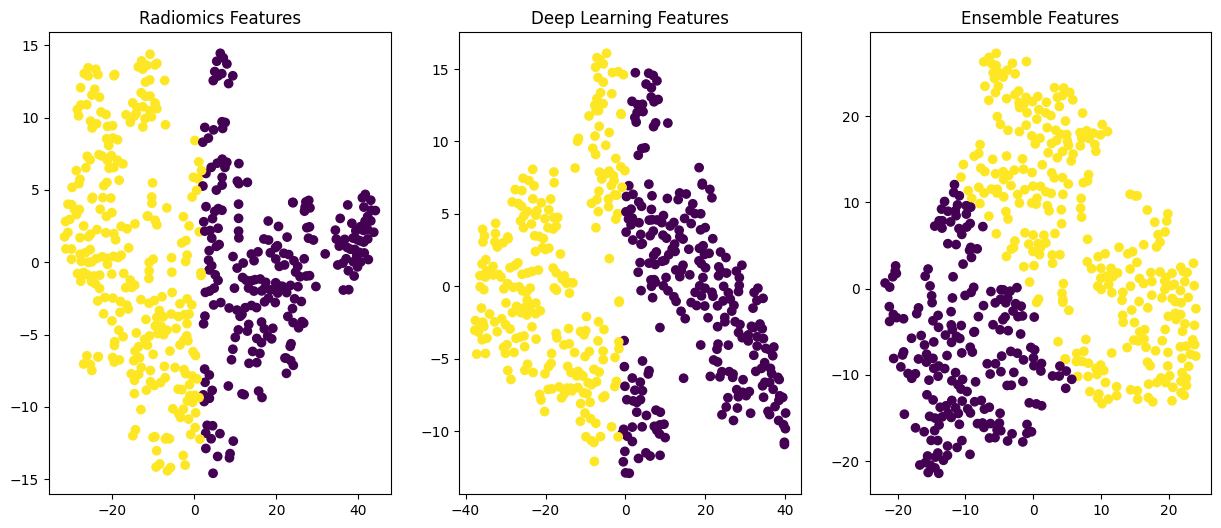

In [15]:
fig, ax = plt.subplots(1, 3, figsize=(15,6))

ax[0].scatter(rad_tsne_frufs[:, 0], rad_tsne_frufs[:, 1], c=get_label(rad_tsne_frufs, labels))
ax[0].set_title("Radiomics Features")

ax[1].scatter(dl_tsne_frufs[:, 0], dl_tsne_frufs[:, 1], c=get_label(dl_tsne_frufs, labels))
ax[1].set_title("Deep Learning Features")

ax[2].scatter(ens_tsne_frufs[:, 0], ens_tsne_frufs[:, 1], c=get_label(ens_tsne_frufs, labels))
ax[2].set_title("Ensemble Features")

plt.savefig("./tsne.png" ,bbox_inches='tight', dpi=1200)

### Ablation Radiomics Plot